In [1]:
### IMPORTS
import sys
sys.path.append('..')
import os
current_path = os.getcwd()
folder = os.path.abspath(os.path.join(current_path, os.pardir))
from classes.graph_simulation import SimWithoutFault
import matplotlib.pyplot as plt
import numpy as np

import skimage as ski
import pandas as pd
file_general_results = '../data/fault_sim/results/general_data.csv'


In [2]:
### PARAMETERS
generate_MG_realisations = False #for scenarios different from 0, it has to be set to True
compute_modflow = True #necessary for the first time
build_graph = True #necessary for the first time
scenario_id = 32

In [3]:
sim = SimWithoutFault(data_path=os.path.join(folder,'data','random_sim')) #class of computation
sim.generate_sim_data() #generates data for the simulation, loads the grid.
scenario = sim.instantiate_scenario(scenario_id=scenario_id) # a scenario is instantiated by its id (depending on the data) 
if generate_MG_realisations:
    sim.generate_MGS() #generates the MG realisations for all the 50 scenarios
sim.generate_K_field(scenario) #generates the conductivity field for the scenario from the MG realisations
if compute_modflow:
    sim.run_MODFLOW(scenario) #runs the MODFLOW simulation with flopy

2024-08-06 12:26:32.935515 - MF6 RUN SCENARIO 40
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package sim_40.gwfgwt...
  writing model faulted_gwf_40...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
    writing package npf...
    writing package wel-1...
    writing package oc...
  writing model faulted_gwt_40...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following executable to run the model: C:\Users\00102908\utilities\mf6.3.0\bin\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW

In [4]:
sim.load_hydro_data(scenario) #Loads K field and modflow data.
#sim.load_graph(scenario)
sim.get_mass_data(scenario) #transforms MF data

2024-08-06 12:32:41.323640 - LOADING K FIELD
2024-08-06 12:32:41.338598 - LOADING MODFLOW RESULTS


True

In [5]:
### Building graph 
if build_graph:
    sim.build_graph(scenario)
sim.load_graph(scenario)

2024-08-06 12:32:41.435871 BUILDING GRAPH
Running topological_analysis version 0.1.19


C:\Users\00102908\Anaconda3\envs\proxyflow\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\00102908\Anaconda3\envs\proxyflow\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\00102908\Anaconda3\envs\proxyflow\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more informa

2024-08-06 12:33:36.979959 GRAPH BUILT


In [6]:
### Computing Dijkstra
distances = sim.compute_dijkstra(scenario)

2024-08-06 12:33:37.006888 - COMPUTING DIJKSTRA WITH IGRAPH
2024-08-06 12:33:38.158737 - DIJKSTRA COMPUTED


Text(0.5, 0, 'y')

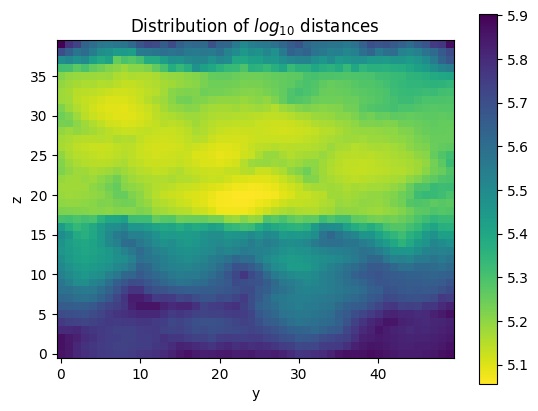

In [7]:
plt.imshow(np.log10(scenario.ig_map), origin='lower',cmap='viridis_r')
plt.colorbar()
plt.title('Distribution of $log_{10}$ distances')
plt.ylabel('z')
plt.xlabel('y')

Text(0.5, 0, 'y')

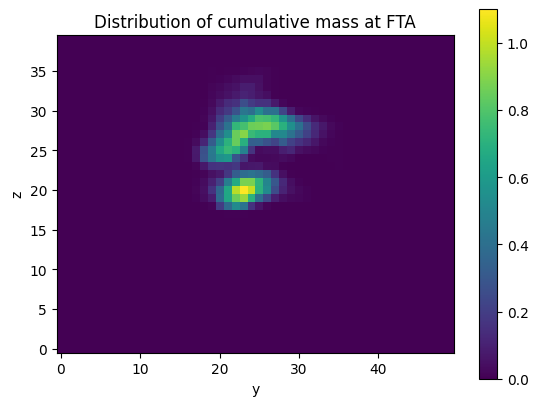

In [8]:
plt.imshow(scenario.mf_map, origin='lower')
plt.colorbar()
plt.title('Distribution of cumulative mass at FTA')
plt.ylabel('z')
plt.xlabel('y')

In [52]:
Pearson, Spearman = sim.compute_Pearson(scenario), sim.compute_Spearman(scenario)
print(f'Pearson coefficient is {Pearson}, Spearman coefficient is {Spearman}')

Pearson coefficient is 0.23829438849353254, Spearman coefficient is 0.9291816537954135


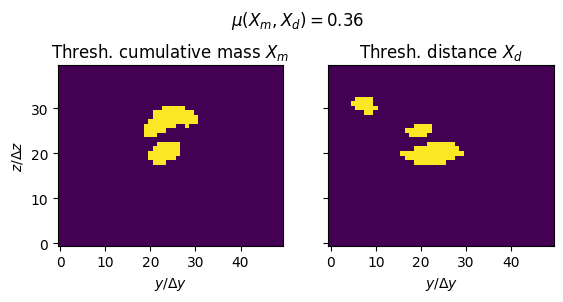

In [11]:
sim.compute_similarity(scenario,plot = True)

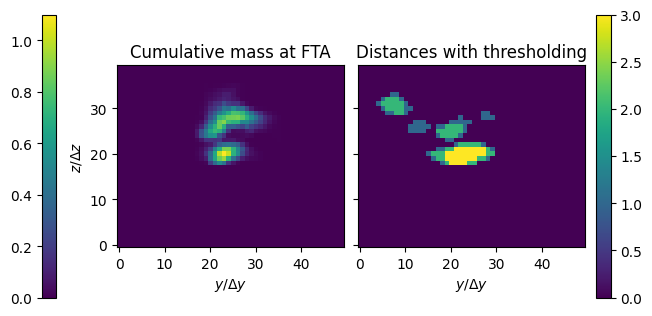

In [10]:
_ = sim.compute_auto_thresh(scenario, plot = True)

In [16]:
# LOAD general results
df = pd.read_csv(file_general_results)

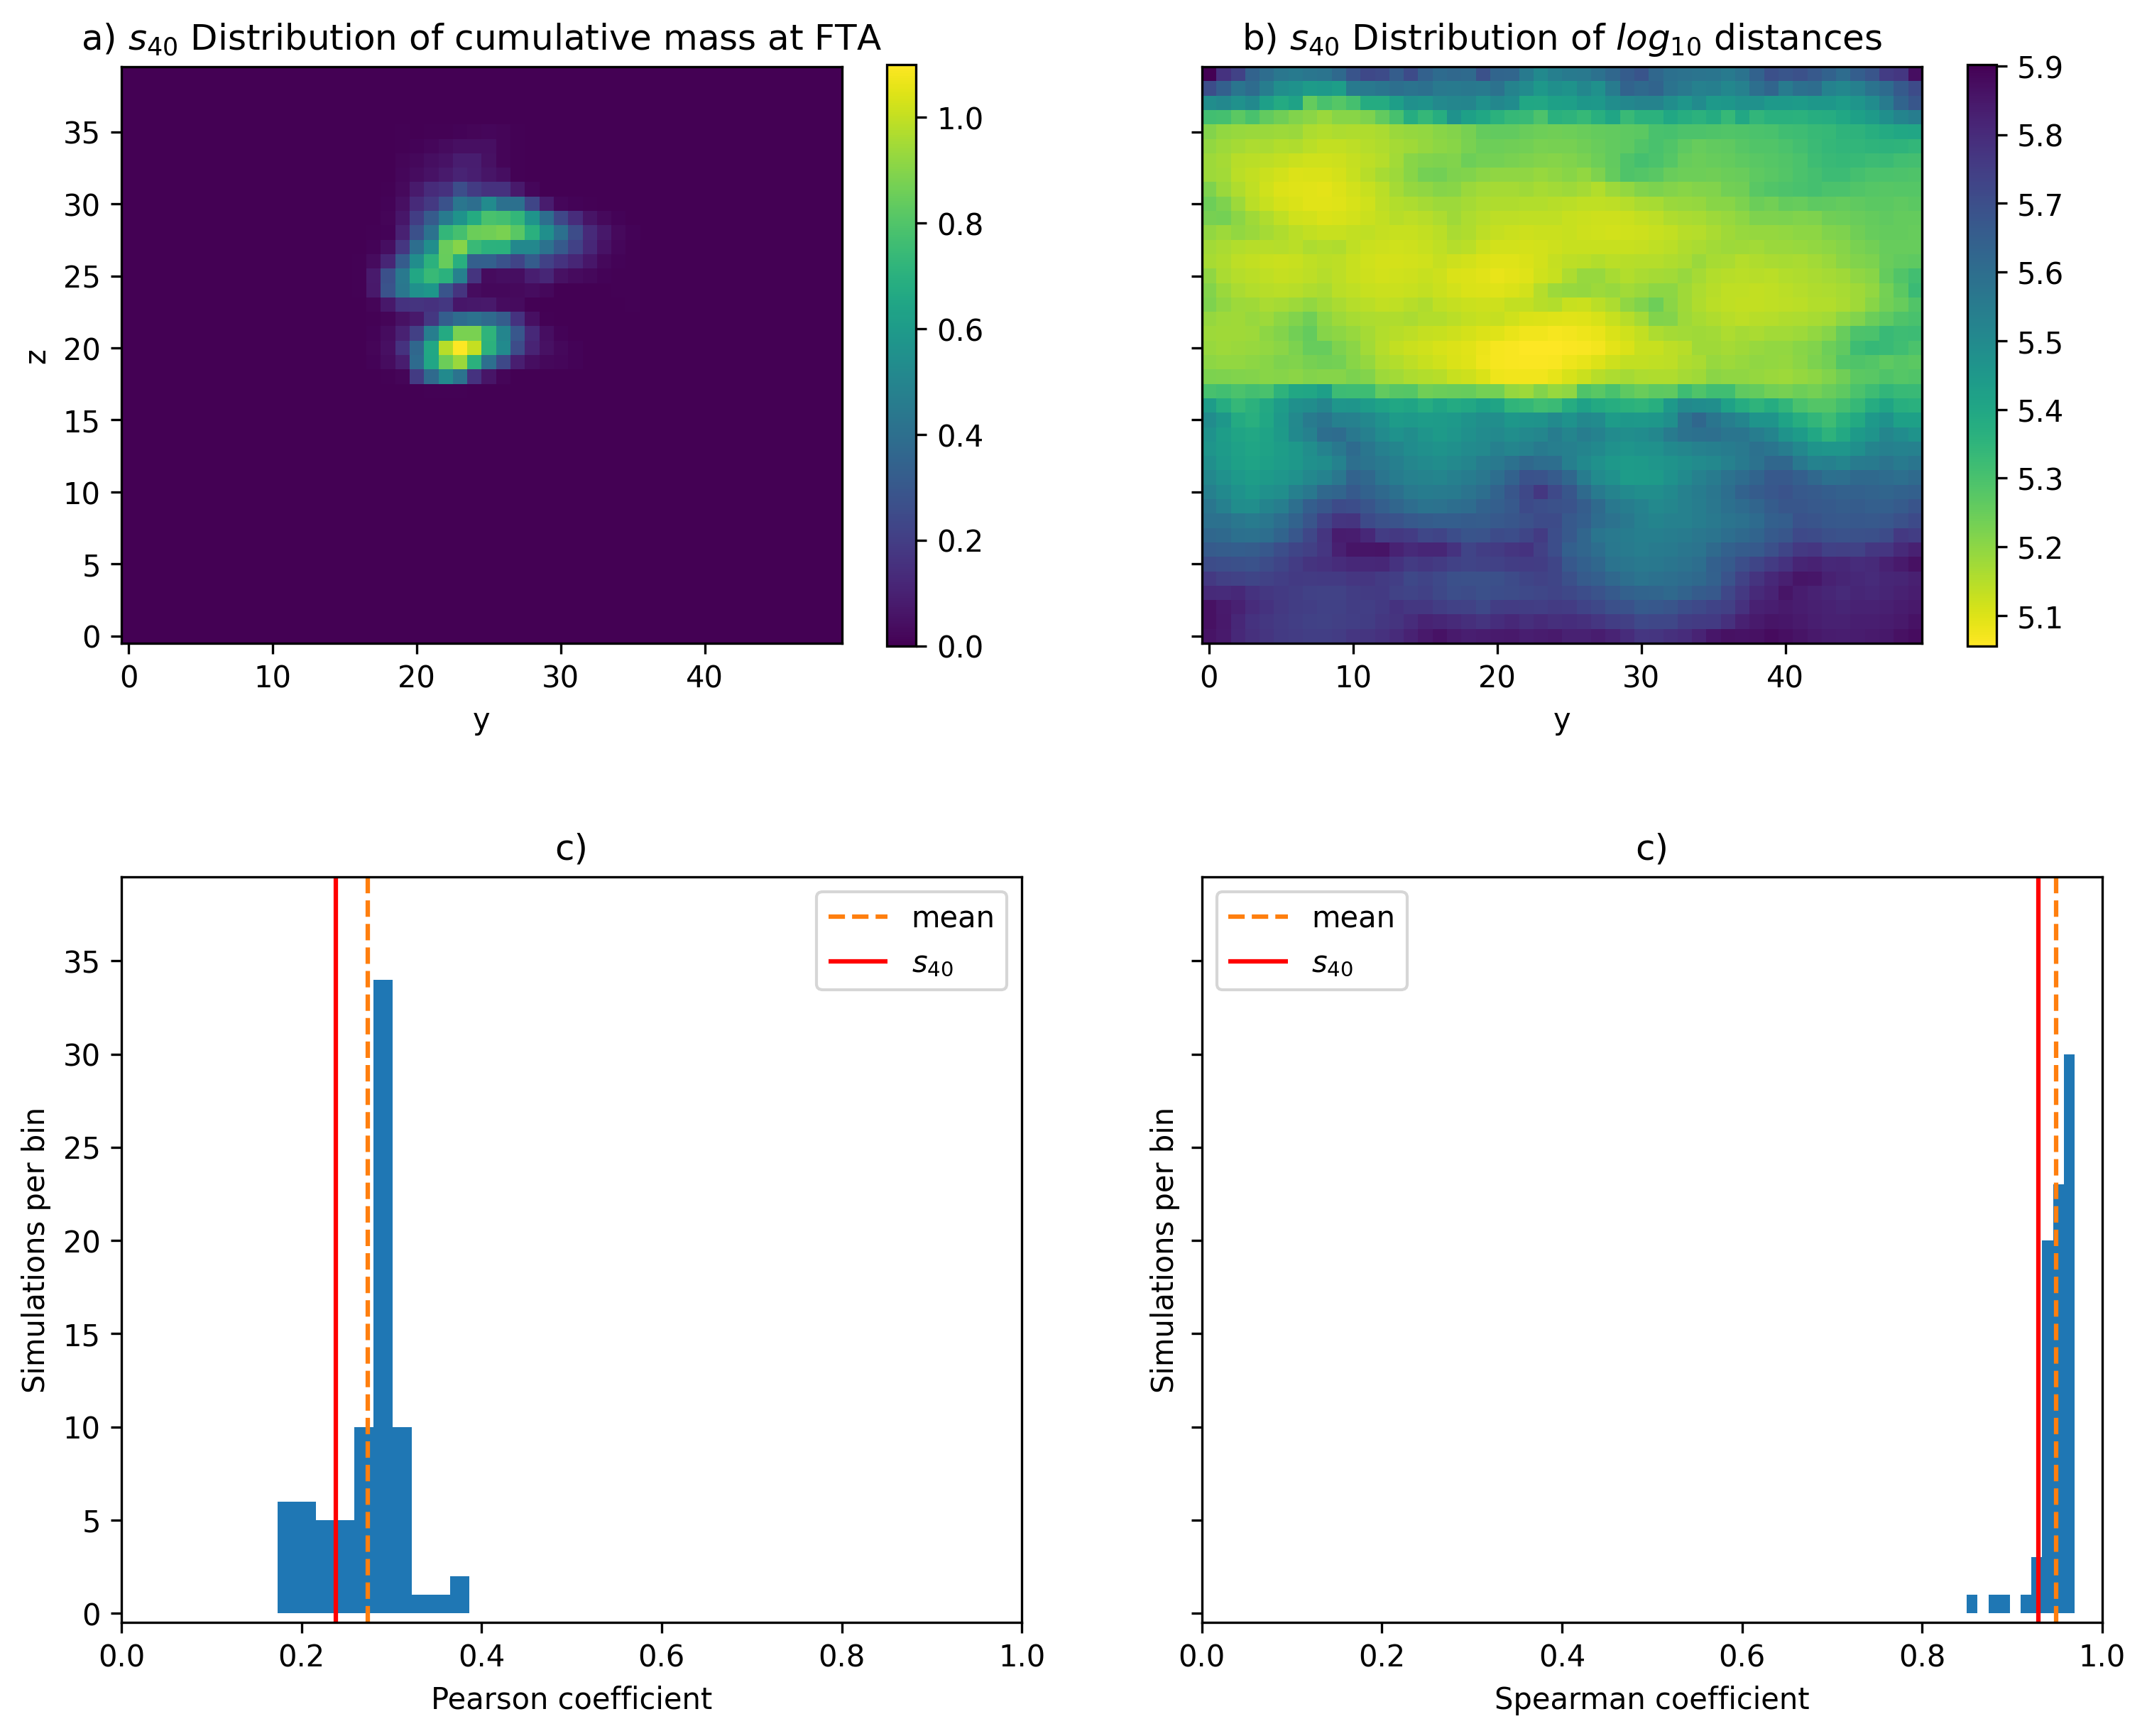

In [64]:
#plt.figure(figsize=(8,4), dpi=300)
plt.subplots(2,2,figsize=(12,10), dpi=300, sharey= True)

plt.subplot(2,2,1)
plt.imshow(scenario.mf_map, origin='lower')
plt.colorbar(shrink=0.78)
plt.title('a) $s_{'+str(scenario_id)+'}$ Distribution of cumulative mass at FTA')
plt.ylabel('z')
plt.xlabel('y')

plt.subplot(2,2,2)
plt.imshow(np.log10(scenario.ig_map), origin='lower',cmap='viridis_r')
plt.colorbar(shrink=0.78)
plt.title('b) $s_{'+str(scenario_id)+'}$ Distribution of $log_{10}$ distances')
#plt.ylabel('z')
plt.xlabel('y')

distance= distances[0]
ax =plt.subplot(2,2,3)
plt.xlim([0,1])
plt.hist(df[distance], 10)
plt.vlines(np.mean(df[distance]),ymin = 0, ymax = 1, color = 'C1', linestyle = '--', transform=ax.get_xaxis_transform(), label='mean')
plt.vlines(eval(distance),ymin = 0, ymax = 1, color = 'r', linestyle = '-', transform=ax.get_xaxis_transform(), label=r'$s_{'+str(scenario_id)+'}$')
plt.xlabel(f"{distance} coefficient")
plt.ylabel('Simulations per bin')
plt.title('c)')
plt.legend(loc='best')

distance= distances[1]
ax =plt.subplot(2,2,4)
plt.xlim([0,1])
plt.hist(df[distance], 10)
plt.vlines(np.mean(df[distance]),ymin = 0, ymax = 1, color = 'C1', linestyle = '--', transform=ax.get_xaxis_transform(), label='mean')
plt.vlines(eval(distance),ymin = 0, ymax = 1, color = 'r', linestyle = '-', transform=ax.get_xaxis_transform(), label=r'$s_{'+str(scenario_id)+'}$')
plt.xlabel(f"{distance} coefficient")
plt.ylabel('Simulations per bin')
plt.title('c)')
plt.legend(loc='upper left')

plt.savefig('../manuscript/figures/examples_and_spearman_s'+str(scenario_id)+'.png')
plt.show()

0.23829438849353254

0.9291816537954135